In [1]:
import sys

sys.path.append("..")

In [2]:
from data.dataloader import LowLightDataModule
from model.blocks.homomorphic import ImageComposition, ImageDecomposition
from model.blocks.illuminationenhancer import IlluminationEnhancer
from utils.utils import show_batch, summarize_model

/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=512,
    batch_size=1,
    num_workers=4,
)

data_module.setup(stage="fit")

In [4]:
train_dataloader = data_module.train_dataloader()

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


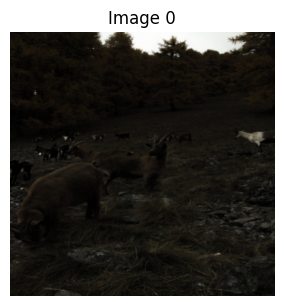

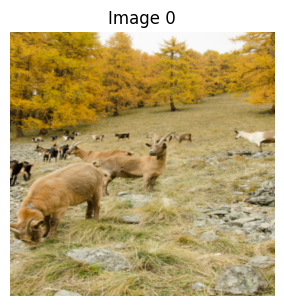

In [5]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
show_batch(images=train_low)
show_batch(images=train_high)

In [6]:
decompose = ImageDecomposition(offset=0.5, raw_cutoff=0.1, trainable=False)
compose = ImageComposition(offset=0.5, trainable=True)

In [7]:
train_low = train_low.cuda()
decompose = decompose.cuda()
compose = compose.cuda()

In [8]:
luminance, chroma_red, chroma_blue, illuminance, reflectance = decompose(train_low)
rgb, lu = compose(chroma_red, chroma_blue, illuminance, reflectance)

In [9]:
unet = IlluminationEnhancer(
    in_channels=1,
    out_channels=1,
    hidden_channels=64,
    num_resolution=4,
    dropout_ratio=0.2,
    trainable=False,
)

In [10]:
unet = unet.cuda()

In [11]:
out = unet(illuminance)

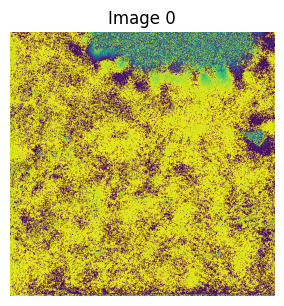

In [12]:
show_batch(images=out)

In [13]:
summarize_model(model=unet, input_size=(1, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
IlluminationEnhancer                     [1, 1, 256, 256]          --
├─Conv2d: 1-1                            [1, 64, 256, 256]         640
├─ModuleList: 1-2                        --                        --
│    └─DoubleConv: 2-1                   [1, 128, 256, 256]        --
│    │    └─ResidualBlock: 3-1           [1, 96, 256, 256]         144,800
│    │    └─ResidualBlock: 3-2           [1, 128, 256, 256]        270,912
│    │    └─Conv2d: 3-3                  [1, 128, 256, 256]        8,320
│    └─Downsampling: 2-2                 [1, 128, 128, 128]        147,584
│    │    └─AvgPool2d: 3-4               [1, 128, 128, 128]        --
│    └─DoubleConv: 2-3                   [1, 256, 128, 128]        --
│    │    └─ResidualBlock: 3-5           [1, 192, 128, 128]        578,368
│    │    └─ResidualBlock: 3-6           [1, 256, 128, 128]        1,082,496
│    │    └─Conv2d: 3-7                  [1, 256, 128,